In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import describe

In [30]:
# # Supongamos que ya cargaste tu DataFrame
# df = pd.read_csv('../data/precios_cervezas_2025.csv')

# df_productos = pd.read_csv("../data/ids_cervezas_enriquecidos.csv")

# # Merge con productos (left join para conservar todos los precios)
# df_merged = df.merge(df_productos, on='id_producto', how='left')

# # Identificá las columnas fijas y las de fechas (pueden ser detectadas automáticamente si querés)
# id_cols = ['id_comercio', 'id_bandera', 'id_sucursal', 'nombre_comercio', 'provincia'] + df_productos.columns.tolist()
# date_cols = [col for col in df.columns if col not in id_cols]

# # Asegurar que los nombres de las columnas de fecha estén en string
# df_merged.columns = df_merged.columns.astype(str)

# # Melt para despivotear
# df_long = df_merged.melt(id_vars=id_cols, value_vars=date_cols,
#                   var_name='fecha', value_name='precio')

# # Convertir fechas de '20250101' a datetime
# df_long['fecha'] = pd.to_datetime(df_long['fecha'], format='%Y%m%d')

# # Ordenar por producto, comercio y fecha
# df_long = df_long.sort_values(by=['id_producto', 'id_comercio', 'fecha'])

# # Opcional: resetear índice
# df_long = df_long.reset_index(drop=True)

# df_long.to_csv("../data/precios_cervezas_2025_transformado.csv", index=False)

In [2]:
df = pd.read_csv('../data/precios_cervezas_2025_transformado.csv')

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_55921/1648959241.py:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/precios_cervezas_2025_transformado.csv')


## Caso de Negocio
### Problema de Negocio
### Objetivo
### Datos Disponibles
### Variable Target
### Población Objetivo
### Periodos Considerados en el Dataset
### Estrategias y Soluciones Propuestas

## Análisis y Limpieza de Datos

In [3]:
df.head()

,id_comercio,id_bandera,id_sucursal,nombre_comercio,provincia,id_producto,productos_descripcion,name,description,brand,...,Width,Binding,Part Number,Manufacturer,Height,Number Of Items,volume_raw,volume_ml,fecha,precio
0,12,1,44,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
1,12,1,45,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
2,12,1,51,COTO CICSA,AR-B,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
3,12,1,56,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0
4,12,1,60,COTO CICSA,AR-C,3162330450010,CERVEZA LAGER STARBERG LAT 500 ML,Cerveza Starberg Lager 500 Ml,No description found.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,500 ml,500.0,2025-01-01,2300.0


In [4]:
df.shape

(22054920, 38)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22054920 entries, 0 to 22054919
Data columns (total 38 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id_comercio            int64  
 1   id_bandera             int64  
 2   id_sucursal            int64  
 3   nombre_comercio        object 
 4   provincia              object 
 5   id_producto            int64  
 6   productos_descripcion  object 
 7   name                   object 
 8   description            object 
 9   brand                  object 
 10  specs                  object 
 11  category               object 
 12  ingredients            object 
 13  specs_parsed           object 
 14  specs_dict             object 
 15  Size                   object 
 16  Country of Origin      object 
 17  Countries              object 
 18  Stores                 object 
 19  Alcohol %              object 
 20  Weight                 object 
 21  Color                  object 
 22  Unit Size & Type

In [6]:
df.describe()

,id_comercio,id_bandera,id_sucursal,id_producto,Number Of Items,volume_ml,precio
count,2.205492e+07,2.205492e+07,2.205492e+07,2.205492e+07,124560.0,2.090280e+07,1.577925e+07
mean,1.098896e+01,1.510183e+00,8.464349e+02,7.651990e+12,2.0,3.442697e+03,4.347986e+03
std,2.712801e+01,8.712664e-01,1.991071e+03,7.620433e+11,0.0,3.635912e+04,4.288552e+03
min,2.000000e+00,1.000000e+00,1.000000e+00,3.162330e+12,2.0,2.850000e+02,2.200000e+01
25%,9.000000e+00,1.000000e+00,1.160000e+02,7.792798e+12,2.0,4.730000e+02,2.275000e+03
50%,1.000000e+01,1.000000e+00,2.880000e+02,7.793147e+12,2.0,4.730000e+02,2.950000e+03
75%,1.500000e+01,2.000000e+00,7.110000e+02,7.793148e+12,2.0,7.100000e+02,4.000000e+03
max,2.013000e+03,5.000000e+00,9.000000e+04,8.725000e+12,2.0,4.730000e+05,7.543200e+04


¿Cuantos productos tienen descripción?

In [7]:
df['TieneDescripcion'] = df['name'].notna().astype(int)

In [8]:
productos_unicos = df[['id_producto', 'TieneDescripcion']].drop_duplicates()
productos_unicos['TieneDescripcion'].value_counts()

TieneDescripcion
1    389
0     55
Name: count, dtype: int64

In [9]:
df['TieneDescripcion'].value_counts()

TieneDescripcion
1    21628320
0      426600
Name: count, dtype: int64

In [10]:
# Nos quedamos unicamente con los productos que tienen descripción
data = df[df['TieneDescripcion'] == 1]

¿Cuál es nuestra cartera de productos?

In [11]:
print('Hay {} productos únicos'.format(data['productos_descripcion'].nunique()))

Hay 350 productos únicos


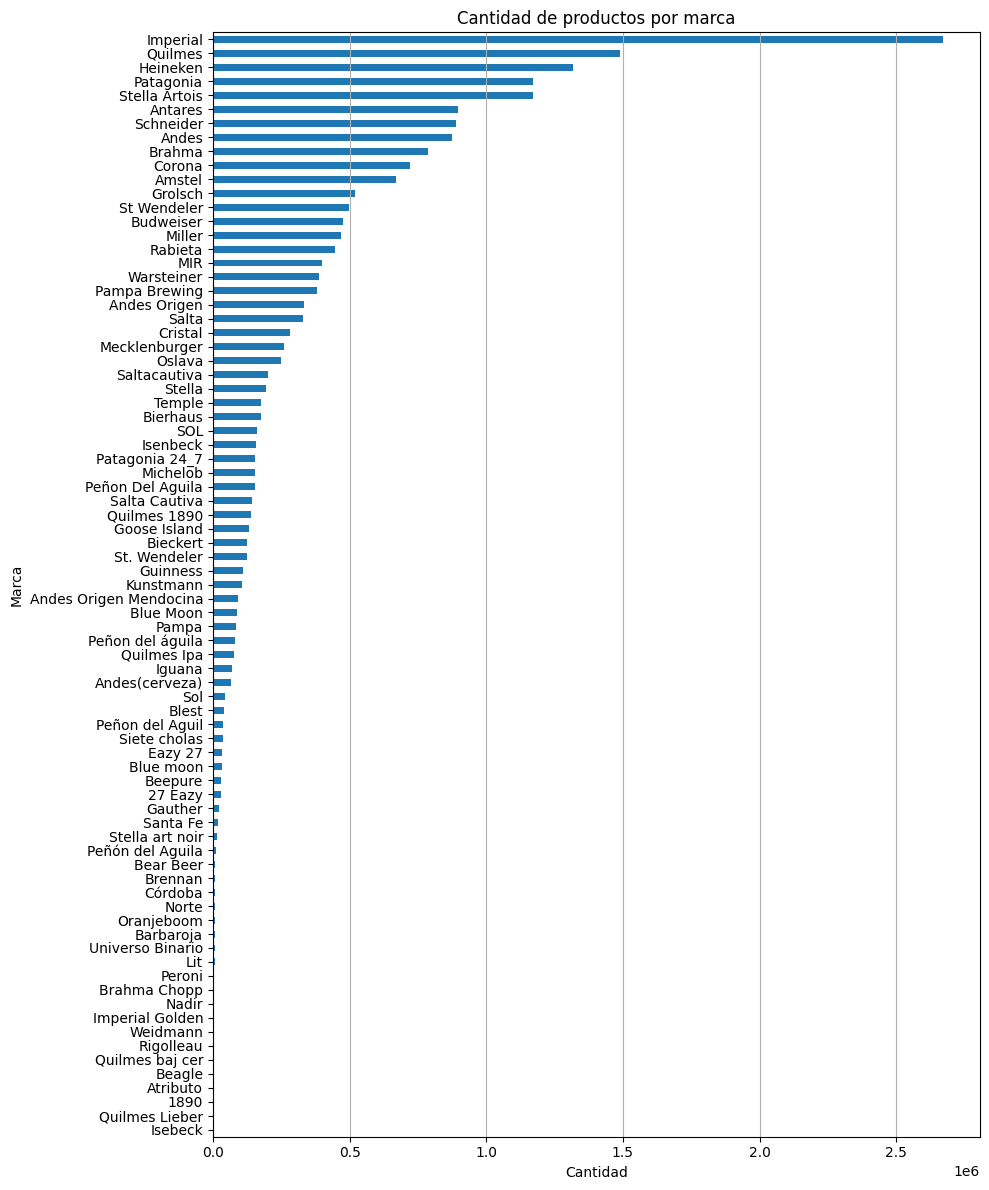

In [17]:
# Suponiendo que ya tenés tu DataFrame cargado como df
brand_counts = data['brand'].value_counts()

# Orden descendente para gráfico horizontal (de mayor a menor arriba)
brand_counts = brand_counts.sort_values(ascending=True)

# Crear gráfico
plt.figure(figsize=(10, 12))
brand_counts.plot(kind='barh')
plt.title('Cantidad de productos por marca')
plt.xlabel('Cantidad')
plt.ylabel('Marca')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

In [45]:
data['brand_clean'] = data['brand'].astype(str).str.upper().str.strip()

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_55921/3728496856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand_clean'] = data['brand'].astype(str).str.upper().str.strip()


In [21]:
%pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [46]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Lista de marcas únicas
marcas_unicas = data['brand_clean'].dropna().unique()

# Elegir una base (por ejemplo, las top 20 marcas)
top_marcas = data['brand_clean'].value_counts().head(40).index.tolist()

# Mapear marcas similares a las top
fuzzy_map = {}
for marca in marcas_unicas:
    mejor_match, score = process.extractOne(marca, top_marcas)
    if score >= 90:  # umbral ajustable
        fuzzy_map[marca] = mejor_match
    else:
        fuzzy_map[marca] = marca  # sin cambio

# Aplicar el mapeo
data['brand_normalizada'] = data['brand_clean'].map(fuzzy_map)

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_55921/3114616872.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand_normalizada'] = data['brand_clean'].map(fuzzy_map)


In [47]:
data['brand_normalizada'].value_counts().sort_index().head(50)

brand_normalizada
27 EAZY               30000
AMSTEL               670920
ANDES               1032960
ANDES ORIGEN         335040
ANTARES              895680
ATRIBUTO               1200
BARBAROJA              6600
BEAGLE                 1320
BEAR BEER              9240
BEEPURE               30840
BIECKERT             125400
BIERHAUS             174360
BLEST                 40440
BLUE MOON            120000
BRAHMA               791280
BUDWEISER            476640
CORONA               720000
CRISTAL              283200
CÓRDOBA                7680
EAZY 27               34080
GAUTHER               20760
GOOSE ISLAND         131520
GROLSCH              520560
GUINNESS             108720
HEINEKEN            1317720
IGUANA                70200
IMPERIAL            2676240
ISENBECK             157080
KUNSTMANN            108120
LIT                    5880
MECKLENBURGER        259440
MICHELOB             153840
MILLER               467640
MIR                  399840
NADIR                  4680
NA

In [51]:
reemplazos_similares = {
    # Marcas duplicadas o mal normalizadas
    'STELLA': 'STELLA ARTOIS',

    'PATAGONIA 24_7': 'PATAGONIA',

    'QUILMES 1890': 'QUILMES',

    'HEINEKEN CERVEZA LATA': 'HEINEKEN',

    'SALTACAUTIVA': 'SALTA CAUTIVA',

    'EAZY 27': '27 EAZY'
}

data['brand_normalizada'] = data['brand_normalizada'].replace(reemplazos_similares)

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_55921/2312935637.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand_normalizada'] = data['brand_normalizada'].replace(reemplazos_similares)


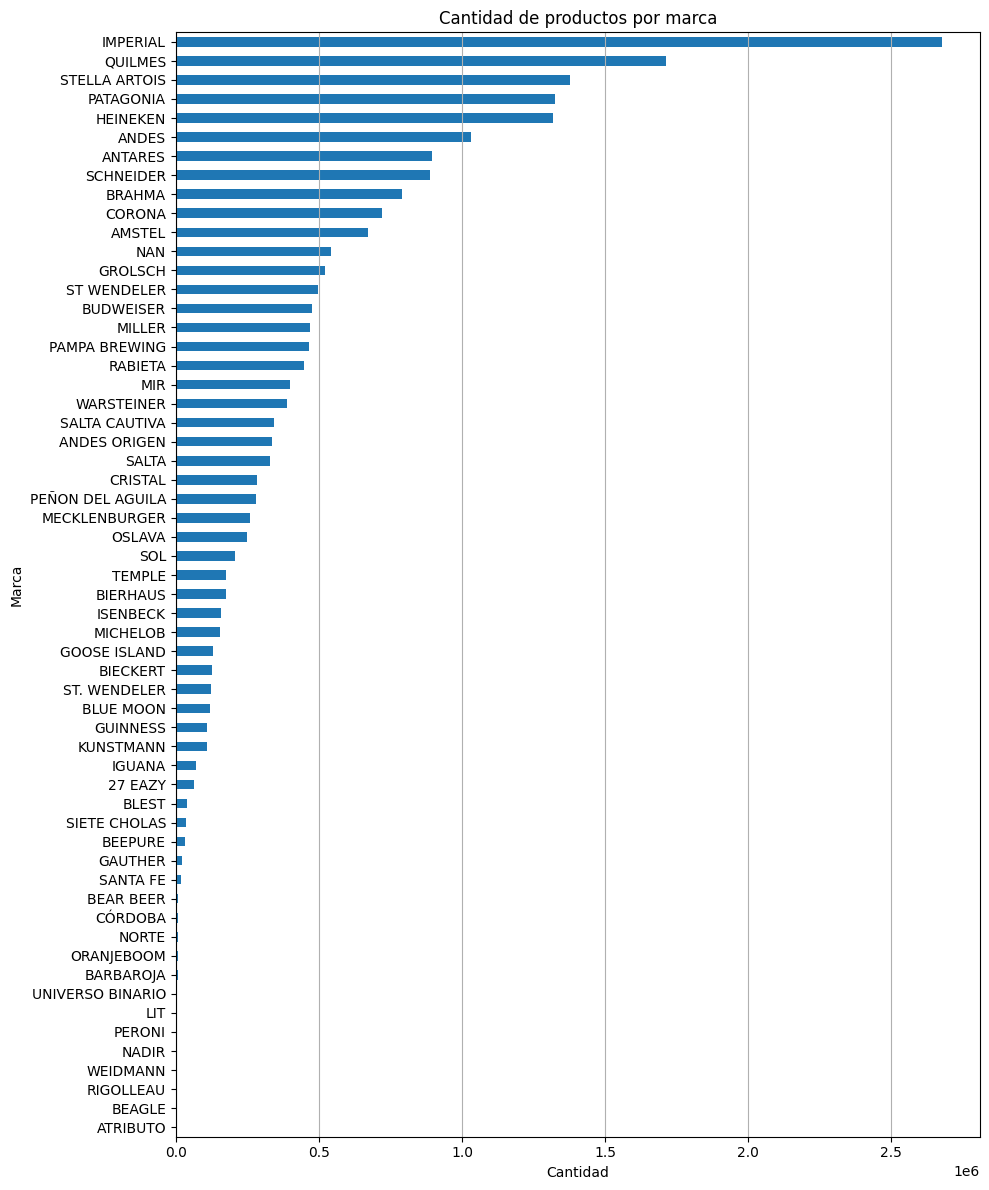

In [52]:
# Suponiendo que ya tenés tu DataFrame cargado como df
brand_counts = data['brand_normalizada'].value_counts()

# Orden descendente para gráfico horizontal (de mayor a menor arriba)
brand_counts = brand_counts.sort_values(ascending=True)

# Crear gráfico
plt.figure(figsize=(10, 12))
brand_counts.plot(kind='barh')
plt.title('Cantidad de productos por marca')
plt.xlabel('Cantidad')
plt.ylabel('Marca')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

In [55]:
reemplazos_similares = {
    # Calibres duplicadas o mal normalizadas
    473000: 473,
    4733: 473,
    470: 473
}

data['volume_ml'] = data['volume_ml'].replace(reemplazos_similares)

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_55921/3348461076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['volume_ml'] = data['volume_ml'].replace(reemplazos_similares)


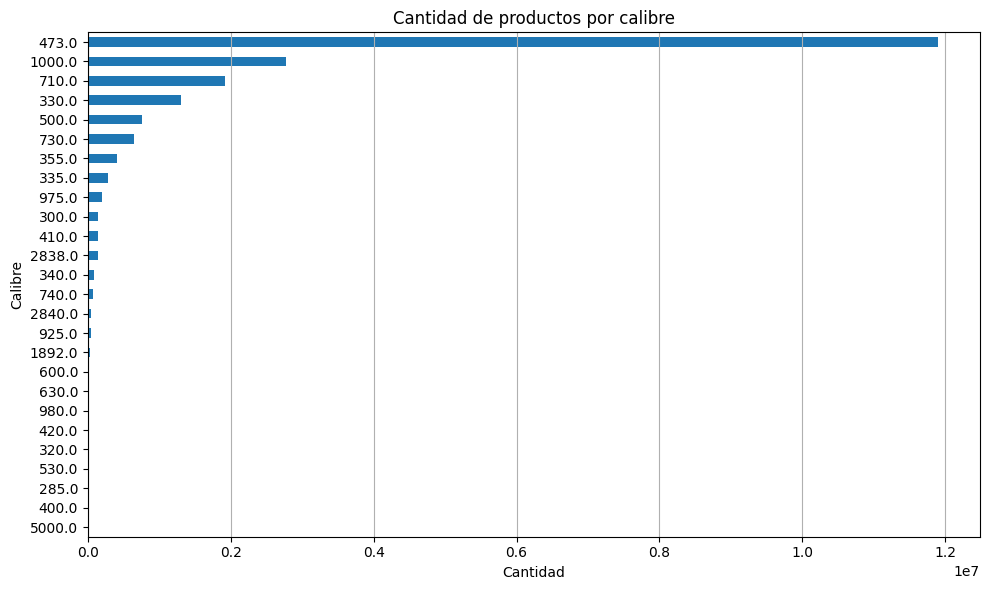

In [56]:
# Suponiendo que ya tenés tu DataFrame cargado como df
brand_counts = data['volume_ml'].value_counts()

# Orden descendente para gráfico horizontal (de mayor a menor arriba)
brand_counts = brand_counts.sort_values(ascending=True)

# Crear gráfico
plt.figure(figsize=(10, 6))
brand_counts.plot(kind='barh')
plt.title('Cantidad de productos por calibre')
plt.xlabel('Cantidad')
plt.ylabel('Calibre')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

¿Hay más de un precio distinto para la misma combinación de producto, comercio, fecha?

In [61]:
# Ver cuántos precios distintos hay por producto, comercio y fecha
variacion = data.groupby(['id_producto', 'id_comercio', 'fecha'])['precio'].nunique().reset_index(name='precios_distintos')

# Filtrar los casos con más de un precio diferente
duplicados = variacion[variacion['precios_distintos'] > 1]

# Mostrar algunos casos
duplicados.head()

,id_producto,id_comercio,fecha,precios_distintos
0,3162330450010,12,2025-01-01,3
1,3162330450010,12,2025-01-02,3
2,3162330450010,12,2025-01-03,3
3,3162330450010,12,2025-01-04,3
4,3162330450010,12,2025-01-05,3


In [64]:
# Tomo el id de comercio y producto con mas duplicados
ejemplo = duplicados.iloc[0]
data[(data['id_producto'] == ejemplo['id_producto']) & (data['id_comercio'] == ejemplo['id_comercio']) & (data['fecha'] == ejemplo['fecha'])].groupby(['id_producto', 'id_comercio', 'fecha'])['precio'].value_counts()

id_producto    id_comercio  fecha       precio
3162330450010  12           2025-01-01  2300.0    39
                                        2375.9     1
                                        2438.0     1
Name: count, dtype: int64

Se filtran duplicados de producto, comercio y fecha tomando la moda del precio. Asi nos desasemos de registros que hacen referencia a sucursales distintas de un mismo comercio. 

In [65]:
# Agrupar por claves únicas
df_sin_duplicados = (
    data.groupby(['id_producto', 'id_comercio', 'fecha'], as_index=False)
      .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

In [67]:
df_sin_duplicados.shape

(174840, 41)

In [68]:
df_sin_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174840 entries, 0 to 174839
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_producto            174840 non-null  int64  
 1   id_comercio            174840 non-null  int64  
 2   fecha                  174840 non-null  object 
 3   id_bandera             174840 non-null  int64  
 4   id_sucursal            174840 non-null  int64  
 5   nombre_comercio        174840 non-null  object 
 6   provincia              174840 non-null  object 
 7   productos_descripcion  174840 non-null  object 
 8   name                   174840 non-null  object 
 9   description            174840 non-null  object 
 10  brand                  168600 non-null  object 
 11  specs                  174840 non-null  object 
 12  category               166680 non-null  object 
 13  ingredients            17160 non-null   object 
 14  specs_parsed           174840 non-nu

In [69]:
df_sin_duplicados.to_csv("../data/precios_cervezas_2025_preprocesado.csv", index=False)